<a href="https://colab.research.google.com/github/TheBlondMyth/AlgoTrading/blob/main/NB3.2_Demo_of_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo of convolutional neural network


---

This notebook gives an example about the implementation of a simple convolutional neural network. The background context is the same as NB 3.1 where we want to predict the outcomes of the process $$y(t)=\sin t + \sin 2t$$ on $t>10$ using the historical observations over $0\leq t\leq 10$.





As before, we import some standard packages to being with.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# Generating of the time series data

We follow the procedures in NB 3.1 to generate the time series data, and then store the results in a pandas dataframe.

In [ ]:
step_size = 0.5 # Each time step in the time series represents 0.5 unit of calendar time

t_sample = np.arange(0, 10 + step_size, step_size)
t_all = np.arange(0, 20 + step_size, step_size)

obs_y = np.sin(t_sample) + np.sin(2*t_sample) # generate the samples
true_y = np.sin(t_all) + np.sin(2*t_all)  # generate the true outcomes over the complete time horizon


data = pd.DataFrame() # create an empty dataframe variable called "data"
data['t'] = t_sample # create a column with name 't', put the values from t_sample to this column
data['y(t)'] = obs_y # create a column with name 'y(t)', put the values from obs_y to this column

display(data) # let's look at what this dataframe is like now

,t,y(t)
0,0.0,0.000000
1,0.5,1.320897
2,1.0,1.750768
3,1.5,1.138615
4,2.0,0.152495
5,2.5,-0.360452
6,3.0,-0.138295
7,3.5,0.306203
8,4.0,0.232556
9,4.5,-0.565412


# Structuring of the feature data

Unlike NB 3.1 where we are using feedforward neural network (FNN), in this notebook we will try to fit a convolutional neural network (CNN) instead.

The key difference between FNN and CNN is that the former takes an input in form of a vector containing all the current and the lagged variables, while the latter takes an input in form of a matrix representing the multivariate time series over a certain window of historical data.

The first step is to specify a window width and prepare the input features data. We will use 10 observations as the window width.

In [ ]:
window = 6

x_train, y_train = [], []

# Loop through the data along the time dimension
for i in range(data.shape[0]):

    # stop the loop once the index gets out of bound
    if i + window > data.shape[0] - 1:
        break

    # Now we write the values from the dataframe to the x_train and y_train variables

    #  WARNING: contrary to usual python slices notation, both the start and the stop are included for pandas dataframe
    x_train.append(data.loc[i : i + window - 1, 'y(t)']) # collect the values of y between time i and i+window-1 (our input series)
    y_train.append(data.loc[i + window, 'y(t)'])    # collect the value of y at time i+window (our target)

# convert the list to numpy array format
x_train = np.array(x_train)
y_train = np.array(y_train)

We can examine the shape of x_train and y_train as follows. x_train now has a shape of (49989, 10). i.e there are 49989 data points, and each data point carries 10 observations.

In [ ]:
print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)

Shape of x_train:  (15, 6)
Shape of y_train:  (15,)


However, the input to a CNN has to be a 3D tensor in form of x_train[data index, time point, channel]. In this example, we are working with a univariate time series so there is only one channel. But for our code to work, we must reshape x_train such that it has a shape of (49989, 10, 1). This lets TensorFlow know that we are working with a time series with one channel only.

This can be achieved by the "reshape" function.

In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

Now let's take a look of the first few data points inside x_train and y_train to confirm that they have the correct values as we expect.

In [ ]:
print("First data point of x_train", x_train[0,:,:])
print("First data point of y_train", y_train[0])
print("Second data point of x_train", x_train[1,:,:])
print("Second data point of y_train", y_train[1])

First data point of x_train [[ 0.        ]
 [ 1.32089652]
 [ 1.75076841]
 [ 1.13861499]
 [ 0.15249493]
 [-0.36045213]]
First data point of y_train -0.13829549013905865
Second data point of x_train [[ 1.32089652]
 [ 1.75076841]
 [ 1.13861499]
 [ 0.15249493]
 [-0.36045213]
 [-0.13829549]]
Second data point of y_train 0.3062033710291692


# Building a convolutional neural network

Now we can proceed to build our convolutional neural network. Let's say we use two convolutional layers. The first one has 4 filters of length 3, and the second one has 8 filters of length 5 (default options for strides and padding). Then we apply global average pooling to collapse the matrix to a vector and pass it to a FNN with one hidden layer with 8 neurons.

In [ ]:
model = tf.keras.models.Sequential()

# First convolutional layer
model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=3, activation='relu', input_shape=(window, 1))) # each input data has size window*1 as there is one channel only

# Second convolutional layer
model.add(tf.keras.layers.Conv1D(filters=8, kernel_size=2, activation='relu'))

# Global average pooling to collapse the matrix into a vector
model.add(tf.keras.layers.GlobalAveragePooling1D())

# Dense hidden layer with 8 neurons
model.add(tf.keras.layers.Dense(8, activation='relu'))

# Final output layer
model.add(tf.keras.layers.Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 4)              16        
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 8)              72        
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 169
Trainable params: 169
Non-trainable params: 0
__________________________________________________________

Now we can train the model.

In [ ]:
model.compile(loss="mean_squared_error")
model.fit(x_train, y_train, epochs=1000, verbose=1)

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 0.9115
Epoch 2/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.8876
Epoch 3/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.8735
Epoch 4/1000
1/1 [==============================] - 0s 12ms/step - loss: 0.8631
Epoch 5/1000
1/1 [==============================] - 0s 16ms/step - loss: 0.8552
Epoch 6/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.8490
Epoch 7/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.8439
Epoch 8/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.8396
Epoch 9/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.8359
Epoch 10/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.8329
Epoch 11/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.8304
Epoch 12/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.8283
Epoch 13/1000
1/1 [========================

# Evaluate the model quality

With the fitted model, let's try to compute the predictions and compare the results against the actual model values. We perform the prediction and write the results to the dataframe in a new column 'predicted y(t+1)'. The actual true model values are written in the column 'actual y(t+1)'.

In [ ]:
data['actual y(t+1)'] = data['y(t)'].shift(-1) # create a column containing the true value of the next step
data=data.dropna()

y_pred = model.predict(x_train) # generate the list of predictions
y_pred = y_pred.flatten()       # by default y_pred is some N by 1 matrix. Flatten this to a vector first

data.loc[window - 1 :, 'predicted y(t+1)'] = y_pred     #write the predictions to this new column

Let's look at the results.

In [ ]:
display(data)

,t,y(t),actual y(t+1),predicted y(t+1)
0,0.0,0.000000,1.320897,NaN
1,0.5,1.320897,1.750768,NaN
2,1.0,1.750768,1.138615,NaN
3,1.5,1.138615,0.152495,NaN
4,2.0,0.152495,-0.360452,NaN
5,2.5,-0.360452,-0.138295,-0.067584
6,3.0,-0.138295,0.306203,0.385902
7,3.5,0.306203,0.232556,0.254842
8,4.0,0.232556,-0.565412,-0.637134
9,4.5,-0.565412,-1.502945,-1.446549


The comparison can be visualised on a plot.

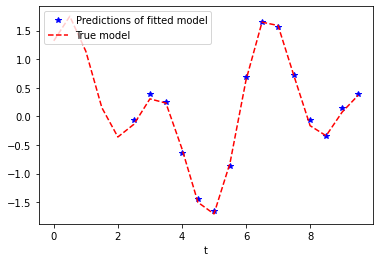

In [ ]:
plt.plot(data['t'], data['predicted y(t+1)'], 'b*', label="Predictions of fitted model")
plt.plot(data['t'], data['actual y(t+1)'], 'r--', label="True model")
plt.xlabel('t')
plt.legend()

# Reflection

It should be pointed out that, for this notebook and NB 3.1, the main purpose is just to illustrate the procedures of constructing a neural network model for time series prediction. The fitting quality in general is good, but don't forget we are working with very few number of data points so the good quality here can be an illusion of overfitting.

But at least one good news is that our CNN model here actually just has 169 parameters, so perhaps the issue of overfitting is less severe......